# 03-123 : Heatmap Model

Create the model definition using the heatmap feature. This model will be later used when training by question.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import mlflow

import keras as k
from keras import optimizers
from competition.models.heatmap_covnet import HeatmapCovnetModel

In [8]:
heatmap_model = HeatmapCovnetModel(
    input_shape=1,
    heatmap_shape=(32, 32, 1),
    output_shape=1,
    loss='mse',
    metrics=['mae']
)

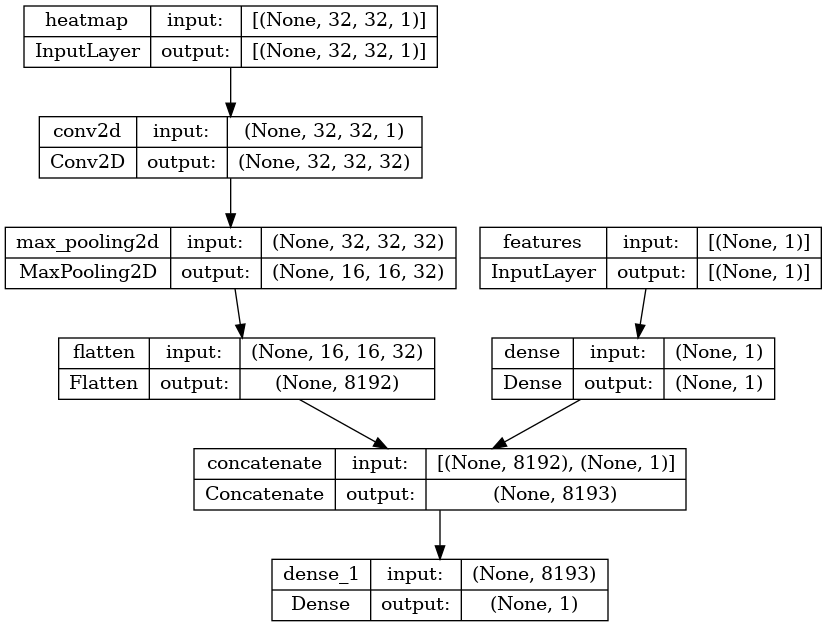

In [9]:
mlflow.end_run()
model = heatmap_model.get_model(
    covnet_block_count=1,
    covnet_activation='relu',
    covnet_cov_count=1,
    covnet_channels=32,
    covnet_kernel_size=(3, 3),
    covnet_pool_size=(2, 2),
    dense_layer_count=1,
    dense_units=1,
    dense_activation='relu',
    dense_l1_regularization=0.0,
    dense_l2_regularization=0.0,
    dense_dropout=0.0,
    compile_model=True,
    optimizer=optimizers.Adam,
    learning_rate=0.001)

k.utils.plot_model(model, show_shapes=True)
